<a href="https://colab.research.google.com/github/atran13/MSc-Thesis-Signs-of-Gentrification/blob/main/Code/best_model_featurevec%26logits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import pandas as pd
import time
import os, glob, copy, random
from PIL import Image
from pandas.core.common import flatten

cudnn.benchmark = True
# plt.ion()   # interactive mode

## Load Data

### SS

In [ ]:
root_dir = '/content/drive/MyDrive/MASTERS/Thesis/Data/in_use/resnet/SS'

In [ ]:
all_image_paths = []
classes = []

for data_path in glob.glob(root_dir + '/*'):
    classes.append(data_path.split('/')[-1])
    all_image_paths.append(glob.glob(data_path + '/*'))

all_image_paths = list(flatten(all_image_paths))
dataset_size = len(all_image_paths)

print(dataset_size)
print(classes)

10079
['gentrified', 'non-gentrified']


### Define custom dataset and transformations

In [ ]:
idx_to_class = {i:j for i, j in enumerate(classes)}
# print(idx_to_class)
class_to_idx = {value:key for key,value in idx_to_class.items()}
print(class_to_idx)

{'gentrified': 0, 'non-gentrified': 1}


In [ ]:
class Gentrification(ImageFolder):
  def __init__(self, paths, transform=True):
    self.paths = paths
    self.transform = transform
    self.data =[]
    for path in paths:
      class_name = path.split('/')[-2]
      self.data.append([path, class_name])

  def __len__(self) :
    return len(self.data)

  def __getitem__(self, idx):
    img_path, label = self.data[idx]
    img = Image.open(img_path)
    img_name = img_path.split('/')[-1]
    label = class_to_idx[label]

    if self.transform:
      return transformation(img), label, img_name

In [ ]:
def transformation(i):
  transform = transforms.Compose([
      transforms.Resize(224),
      transforms.CenterCrop(224),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      ])
  t = transform(i)
  return t

### Load data with random sampler

In [ ]:
# data = Gentrification(all_image_paths)
data = Gentrification(all_image_paths[:2])

In [ ]:
batch_size = 2
dataloader = torch.utils.data.DataLoader(data, batch_size=batch_size, num_workers=2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

### Visualize images



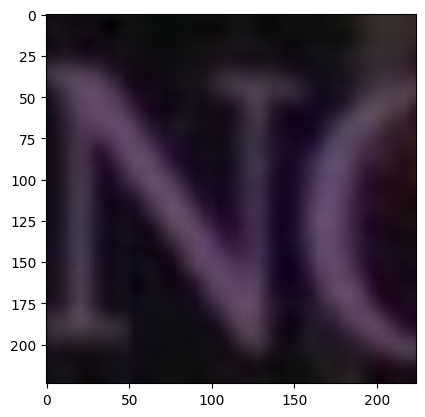

In [ ]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, labels, names = next(iter(dataloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out)

## Get logits & preds



In [ ]:
def get_preds(model, dataloader):
    img_name = []
    label = []
    logits = []
    prediction = []

    with torch.no_grad():
        model.eval()
        for inputs,labels,names in dataloader:
            img_name.extend([n for n in names])
            label.extend([l.item() for l in labels])

            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, pred = torch.max(outputs, 1)

            outputs = outputs.cpu()
            logits.extend(outputs.tolist())

            pred = pred.cpu()
            prediction.extend(pred.tolist())

    d = {'img_name':img_name, 'label':label, 'prediction':prediction, 'logits':logits}
    df = pd.DataFrame(d)

    return df

### Load model

In [ ]:
model = torchvision.models.resnet50()
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

model_pth = '/content/drive/MyDrive/MASTERS/Thesis/Code/models/Train&Val&Test=SS/models/iter3.1*_ft_lr=0.01_bs=64_ep=60.pth'
model.load_state_dict(torch.load(model_pth))
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### Get prediction

#### Pano

In [ ]:
dir = '/content/drive/MyDrive/MASTERS/Thesis/Data/in_use/resnet/pano'

In [ ]:
pano_image_paths = []
classes = []

for data_path in glob.glob(dir + '/*'):
    classes.append(data_path.split('/')[-1])
    pano_image_paths.append(glob.glob(data_path + '/*'))

pano_image_paths = list(flatten(pano_image_paths))
data_size_pano = len(pano_image_paths)

gen_count = 0
non_count = 0
for path in pano_image_paths:
    label = path.split('/')[-2]
    if label == 'gentrified':
        gen_count +=1
    else:
        non_count +=1

print('test_image_paths size (pano):', data_size_pano)
print(f'Class ratio: gentrified - {gen_count} ({(100 * gen_count/data_size_pano):.2f}%) | non-gentrified - {non_count} ({(100 * non_count/data_size_pano):.2f}%)')

test_image_paths size (pano): 2473
Class ratio: gentrified - 1633 (66.03%) | non-gentrified - 840 (33.97%)


In [ ]:
data_pano = Gentrification(pano_image_paths)
len(data_pano)

2473

In [ ]:
batch_size = 64
pano_dataloader = torch.utils.data.DataLoader(data_pano, batch_size=batch_size, num_workers=2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
df_pano = get_preds(model, pano_dataloader)

In [ ]:
len(df_pano)

2473

In [ ]:
df_pano.head()

,img_name,label,prediction,logits
0,20230227TMX7316010203-002985pano_0000_000113_4...,0,1,"[-0.8720466494560242, 0.9993380308151245]"
1,20210317TMX7316010203-002044pano_0000_001722_4...,0,0,"[0.5854475498199463, -0.44877102971076965]"
2,20210317TMX7316010203-002044pano_0000_000786_4...,0,0,"[0.8320134878158569, -0.627690315246582]"
3,20230227TMX7316010203-002985pano_0000_000113_4...,0,1,"[-1.894683837890625, 2.128199815750122]"
4,20220429TMX7316010203-002550pano_0000_000417_4...,0,1,"[0.027477893978357315, 0.11199470609426498]"


In [ ]:
df_pano.to_csv('/content/drive/MyDrive/MASTERS/Thesis/Code/models/df_resnet_pano.csv')

#### SS

In [ ]:
df = get_preds(model)
df.head()

,img_name,label,prediction,logits
0,1442_rec-4.jpg,0,0,"[0.745664656162262, -0.5221627950668335]"
1,1442_rec-3.jpg,0,0,"[1.0457912683486938, -0.6305771470069885]"
2,1442_rec-0.jpg,0,0,"[0.5490521192550659, -0.28820109367370605]"
3,1442_rec-2.jpg,0,0,"[0.7427459955215454, -0.5331131219863892]"
4,1442_rec-1.jpg,0,0,"[0.7099773287773132, -0.39124104380607605]"


In [ ]:
len(df)

10079

In [ ]:
df.to_csv('/content/drive/MyDrive/MASTERS/Thesis/Data/in_use/clustering/df_preds.csv')

# Get feature vectors

In [ ]:
def get_feature_vec(model):
    img_name = []
    feature_vec = []

    with torch.no_grad():
        model.eval()
        for inputs,labels,names in dataloader:
            img_name.extend([n for n in names])

            inputs = inputs.to(device)

            outputs = model(inputs)
            outputs = outputs.cpu()
            feature_vec.extend([o.flatten().tolist() for o in outputs])

    d = {'img_name':img_name, 'feature_vec':feature_vec}
    # df = pd.DataFrame(d)

    # return df
    return d

In [ ]:
d = get_feature_vec(feature_extractor)
d

<ipython-input-36-e43fae6c9518>:16: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  feat = np.array(feature_vec)
<ipython-input-36-e43fae6c9518>:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  feat = np.array(feature_vec)


(2,)

In [ ]:
print(len(d['img_name']))
print(len(d['feature_vec']))
print(type(d['feature_vec']))
print((d['feature_vec'].shape))
print(len(d['feature_vec'][0]))

2
2
<class 'numpy.ndarray'>
torch.Size([2048, 1, 1])
2048


In [ ]:
feature_extractor = torch.nn.Sequential(*list(model.children())[:-1])
feature_extractor.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [ ]:
df1 = pd.DataFrame(d)
len(df1)

10079

In [ ]:
df1.to_csv('/content/drive/MyDrive/MASTERS/Thesis/Data/in_use/clustering/df_feature_vec.csv')

### merge

In [ ]:
df_preds = pd.read_csv('/content/drive/MyDrive/MASTERS/Thesis/Data/in_use/clustering/df_preds.csv')
len(df_preds)

10079

In [ ]:
df_main = df_preds.merge(df1)
df_main.head()

,Unnamed: 0,img_name,label,prediction,logits,feature_vec
0,0,1442_rec-4.jpg,0,0,"[0.745664656162262, -0.5221627950668335]","[0.05507045239210129, 0.25648850202560425, 0.1..."
1,1,1442_rec-3.jpg,0,0,"[1.0457912683486938, -0.6305771470069885]","[0.02460232563316822, 0.07082023471593857, 0.0..."
2,2,1442_rec-0.jpg,0,0,"[0.5490521192550659, -0.28820109367370605]","[0.05572088435292244, 0.13573312759399414, 0.0..."
3,3,1442_rec-2.jpg,0,0,"[0.7427459955215454, -0.5331131219863892]","[0.053557004779577255, 0.15655845403671265, 0...."
4,4,1442_rec-1.jpg,0,0,"[0.7099773287773132, -0.39124104380607605]","[0.04757247492671013, 0.10901347547769547, 0.1..."


In [ ]:
len(df_main)

10079

In [ ]:
df_main.to_csv('/content/drive/MyDrive/MASTERS/Thesis/Data/in_use/clustering/df_resnet.csv')